In [5]:
import numpy as np

import numpy as np

def inverse_kinematics(x, z, l1, l2, l3, z_offset=0.27):
    """
    Inverse kinematics for a 3DOF planar robot arm in X-Z plane.
    
    Parameters:
    x, z       : float - End-effector target position in global frame
    l1, l2, l3 : float - Lengths of the links
    z_offset   : float - Z-offset from base to first joint (default: 0.27m)

    Returns:
    theta1, theta2, theta3 : Joint angles (in radians)
    """
    try:
        # Adjust z coordinate by subtracting the z_offset
        z_adjusted = z - z_offset
        
        # Compute φ as the angle from base to end-effector
        phi = np.arctan2(z_adjusted, x)

        # Step 1: Compute wrist position
        x2 = x - l3 * np.cos(phi)
        z2 = z_adjusted - l3 * np.sin(phi)

        # Step 2: Compute theta2 using cosine law
        D = (x2**2 + z2**2 - l1**2 - l2**2) / (2 * l1 * l2)
        if np.abs(D) > 1:
            raise ValueError(f"Target ({x:.3f}, {z:.3f}) is out of reach")

        theta2 = np.arccos(D)

        # Step 3: Compute theta1
        k1 = l1 + l2 * np.cos(theta2)
        k2 = l2 * np.sin(theta2)
        theta1 = np.arctan2(z2, x2) - np.arctan2(k2, k1)

        # Step 4: Compute theta3
        theta3 = phi - (theta1 + theta2)

        # Normalize angles to [-pi, pi]
        angles = [theta1, theta2, theta3]
        angles = [np.mod(angle + np.pi, 2 * np.pi) - np.pi for angle in angles]

        # Check joint limits
        if not all(-np.pi <= angle <= np.pi for angle in angles):
            raise ValueError("Solution exceeds joint limits")

        return angles[0], angles[1], angles[2]
        
    except Exception as e:
        raise ValueError(f"Inverse kinematics failed: {str(e)}")


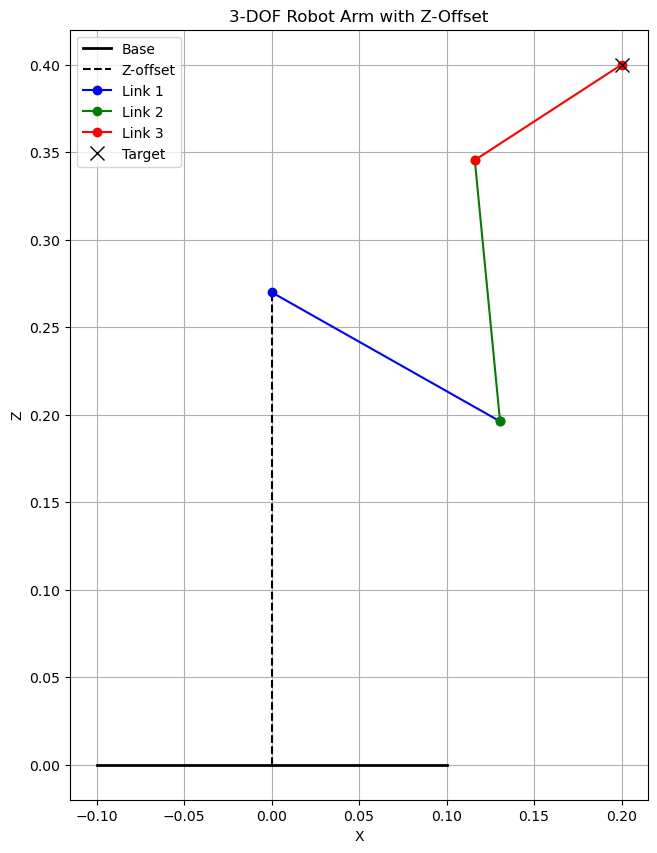


Configuration Details:
Target position: (0.200, 0.400)
Joint angles (degrees):
θ1: -29.47°
θ2: 124.99°
θ3: -62.50°


In [6]:
import matplotlib.pyplot as plt

# Link lengths from URDF
l1, l2, l3 = 0.15, 0.15, 0.10
z_offset = 0.27  # Z-offset from base to first joint

# Target end-effector position in global frame
x_target, z_target = 0.2, 0.4

try:
    # Compute joint angles
    theta1, theta2, theta3 = inverse_kinematics(x_target, z_target, l1, l2, l3, z_offset)
    
    # Forward kinematics to get joint positions
    joint1 = (0, z_offset)  # First joint position with z-offset
    joint2 = (l1 * np.cos(theta1), l1 * np.sin(theta1) + z_offset)
    joint3 = (joint2[0] + l2 * np.cos(theta1 + theta2),
             joint2[1] + l2 * np.sin(theta1 + theta2))
    end_effector = (joint3[0] + l3 * np.cos(theta1 + theta2 + theta3),
                   joint3[1] + l3 * np.sin(theta1 + theta2 + theta3))
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Draw base
    ax.plot([-0.1, 0.1], [0, 0], 'k-', linewidth=2, label='Base')
    ax.plot([0, 0], [0, z_offset], 'k--', label='Z-offset')
    
    # Plot robot links
    ax.plot([joint1[0], joint2[0]], [joint1[1], joint2[1]], 'bo-', label='Link 1')
    ax.plot([joint2[0], joint3[0]], [joint2[1], joint3[1]], 'go-', label='Link 2')
    ax.plot([joint3[0], end_effector[0]], [joint3[1], end_effector[1]], 'ro-', label='Link 3')
    ax.plot(x_target, z_target, 'kx', label='Target', markersize=10)
    
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_title('3-DOF Robot Arm with Z-Offset')
    ax.legend()
    
    plt.show()
    
    # Print configuration details
    print(f"\nConfiguration Details:")
    print(f"Target position: ({x_target:.3f}, {z_target:.3f})")
    print(f"Joint angles (degrees):")
    print(f"θ1: {np.degrees(theta1):.2f}°")
    print(f"θ2: {np.degrees(theta2):.2f}°")
    print(f"θ3: {np.degrees(theta3):.2f}°")
    
except ValueError as e:
    print(f"Error: {str(e)}")


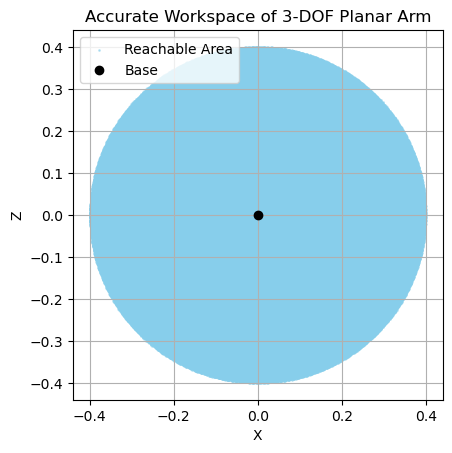

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def get_workspace_points(l1, l2, l3, resolution=100):
    """
    Generate reachable (x, z) points for a 3-DOF planar robot arm.

    Parameters:
    l1, l2, l3 : float - Link lengths
    resolution : int - Number of steps for each joint angle

    Returns:
    np.array of (x, z) reachable points
    """
    theta1_range = np.linspace(-np.pi, np.pi, resolution)
    theta2_range = np.linspace(-np.pi, np.pi, resolution)
    theta3_range = np.linspace(-np.pi, np.pi, resolution // 2)

    points = []
    for t1 in theta1_range:
        for t2 in theta2_range:
            for t3 in theta3_range:
                x1 = l1 * np.cos(t1)
                z1 = l1 * np.sin(t1)
                x2 = x1 + l2 * np.cos(t1 + t2)
                z2 = z1 + l2 * np.sin(t1 + t2)
                x3 = x2 + l3 * np.cos(t1 + t2 + t3)
                z3 = z2 + l3 * np.sin(t1 + t2 + t3)
                points.append((x3, z3))
    return np.array(points)

# Link lengths
l1, l2, l3 = 0.15, 0.15, 0.10

# Get reachable points
reachable_points = get_workspace_points(l1, l2, l3)

# Plotting
fig, ax = plt.subplots()
ax.scatter(reachable_points[:, 0], reachable_points[:, 1], s=1, color='skyblue', alpha=0.5, label='Reachable Area')
ax.plot(0, 0, 'ko', label='Base')

ax.set_aspect('equal')
ax.grid(True)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_title('Accurate Workspace of 3-DOF Planar Arm')
ax.legend()
plt.show()
